In [ ]:
!nvidia-smi

Sat Mar 16 04:24:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install transformers

In [ ]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/multilabel_classification"
df = pd.read_csv(os.path.join(data_dir, "data.csv"))

In [ ]:
df.head()

,id,readme,Dependency management,Support,Testing,Reporting,Mobile CI,Community,Security,Chat,...,Deployment,Container CI,Localization,Utilities,Desktop tools,AI Assisted,Time tracking,Code Scanning Ready,Backup Utilities,Learning
0,actions/checkout,b'[![Build and Test](https://github.com/action...,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,actions/setup-python,"b""# setup-python\n\n[![Basic validation](https...",0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,avsm/setup-ocaml,b'# Set up OCaml\n\n[![Main workflow](https://...,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,actions/upload-artifact,b'# Upload-Artifact v3\n\nThis uploads artifac...,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,peaceiris/actions-gh-pages,"b'<h2 align=""center"">\nGitHub Pages Action\n</...",0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape[0]

1213

In [ ]:
df["text"] = df["id"] + " " + df["readme"]
df.drop(columns=["id", "readme"], axis=1, inplace=True)

NameError: name 'df' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, random_state=42, test_size=0.20, shuffle=True)

train_df, validation_df = train_test_split(train_df, random_state=42, test_size=0.10, shuffle=True)

In [ ]:
print(f"Train: {train_df.shape}, Test: {test_df.shape}, Validation: {validation_df.shape}")

Train: (873, 31), Test: (243, 31), Validation: (97, 31)


In [ ]:
# model hyperparameters

MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALIDATION_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_df["text"]

564     varunsridharan/action-wp-org-deploy b'# WordPr...
1091    timkrase/phpunit-coverage-badge b'# phpunit-co...
822     RafikFarhad/clang-format-github-action b'# Cla...
1087    MilesChou/composer-action b'# Docker and GitHu...
646     alexellis/upload-assets b'# upload-assets\n\nG...
                              ...                        
543     sot/setup-miniconda b'# `conda-incubator/setup...
788     tibdex/autosquash b'<h1 align="center">\n  <im...
642     franzbischoff/replace_envs b"[![Gitpod ready-t...
444     imjohnbo/gh-polls-bot-action b'<p align="cente...
720     sarisia/actions-status-discord b'# Actions Sta...
Name: text, Length: 873, dtype: object

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }



In [ ]:
target_list = list([col for col in train_df.columns if col!="text"])
target_list

['Dependency management',
 'Support',
 'Testing',
 'Reporting',
 'Mobile CI',
 'Community',
 'Security',
 'Chat',
 'IDEs',
 'Monitoring',
 'Code review',
 'Code quality',
 'Publishing',
 'Project management',
 'API management',
 'Open Source management',
 'Mobile',
 'Code search',
 'GitHub Sponsors',
 'Continuous integration',
 'Deployment',
 'Container CI',
 'Localization',
 'Utilities',
 'Desktop tools',
 'AI Assisted',
 'Time tracking',
 'Code Scanning Ready',
 'Backup Utilities',
 'Learning']

In [ ]:
category_freq = df[target_list].sum()/df.shape[0]
category_freq

Dependency management     0.072547
Support                   0.009893
Testing                   0.083265
Reporting                 0.028854
Mobile CI                 0.006595
Community                 0.019786
Security                  0.029678
Chat                      0.029678
IDEs                      0.004122
Monitoring                0.011542
Code review               0.084089
Code quality              0.105523
Publishing                0.122012
Project management        0.062655
API management            0.010717
Open Source management    0.063479
Mobile                    0.003298
Code search               0.005771
GitHub Sponsors           0.000824
Continuous integration    0.356966
Deployment                0.159110
Container CI              0.048640
Localization              0.002473
Utilities                 0.330585
Desktop tools             0.007420
AI Assisted               0.003298
Time tracking             0.000824
Code Scanning Ready       0.001649
Backup Utilities    

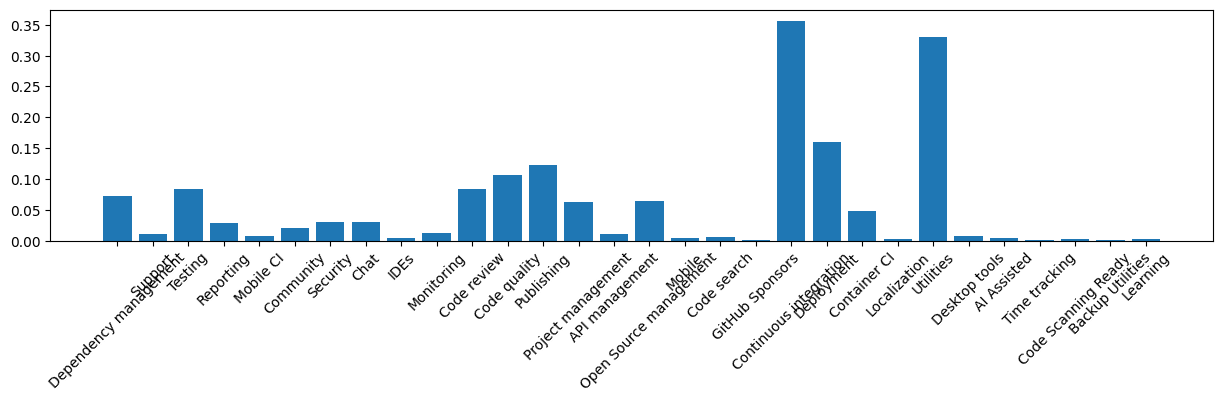

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,3)
plt.bar(category_freq.index, category_freq.values)
_ = plt.xticks(rotation=45)

In [ ]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN, target_list)
validation_dataset = CustomDataset(validation_df, tokenizer, MAX_LEN, target_list)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=VALIDATION_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(target_list))

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
def loss_function(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,30)
        loss = loss_function(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [ ]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_function(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_dataloader, model, optimizer)
    val_acc, val_loss = eval_model(validation_dataloader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"output","MultiLabelClassifier.bin"))
        best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=0.6157, val_loss=0.5004 train_acc=0.6800, val_acc=0.8969
Epoch 2/10


  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=0.4569, val_loss=0.3973 train_acc=0.9229, val_acc=0.9385
Epoch 3/10


  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=0.3705, val_loss=0.3328 train_acc=0.9435, val_acc=0.9385
Epoch 4/10


  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=0.3136, val_loss=0.2769 train_acc=0.9444, val_acc=0.9385
Epoch 5/10


  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=0.2719, val_loss=0.2449 train_acc=0.9442, val_acc=0.9385
Epoch 6/10


  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=0.2445, val_loss=0.2303 train_acc=0.9443, val_acc=0.9385
Epoch 7/10


  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=0.2258, val_loss=0.2057 train_acc=0.9443, val_acc=0.9385
Epoch 8/10


  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=0.2124, val_loss=0.2070 train_acc=0.9443, val_acc=0.9385
Epoch 9/10


  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=0.2021, val_loss=0.1953 train_acc=0.9443, val_acc=0.9385
Epoch 10/10


  0%|          | 0/28 [00:00<?, ?it/s]

train_loss=0.1957, val_loss=0.1943 train_acc=0.9444, val_acc=0.9385


In [ ]:
import matplotlib.pyplot as plt

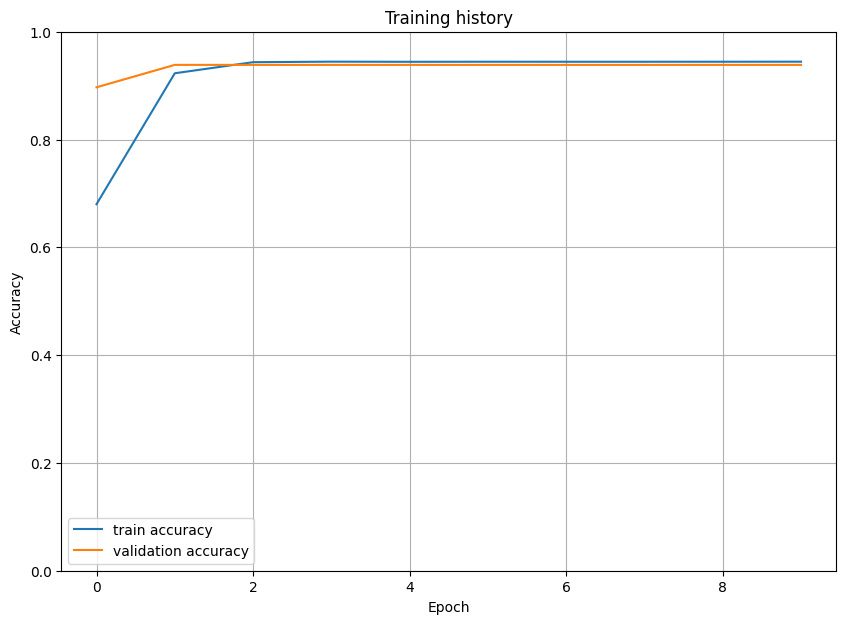

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

Model Evaluation

In [ ]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(data_dir,"output","MultiLabelClassifier.bin")))
model = model.to(device)

In [ ]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_dataloader, model, optimizer)

In [ ]:
test_acc

0.9463648834019205

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions -
    """
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values

In [ ]:
texts, predictions, prediction_probs, target_values = get_predictions(model, test_dataloader)

{'input_ids': tensor([[  101,  1046, 27767,  ...,  2064,  2022,   102],
        [  101, 16729,  6155,  ...,  8450,  1999,   102],
        [  101, 15536,  2361,  ...,  1050,  1032,   102],
        ...,
        [  101,  9395, 16147,  ...,  5371,  1033,   102],
        [  101, 24665,  4215,  ...,  5310,  1011,   102],
        [  101, 24004,  7630,  ...,  2121,  1007,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'targets': tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],

In [ ]:
predictions.numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
print(f"text:{len(texts)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

text:243 
predictions:torch.Size([243, 30]) 
prediction_probs:torch.Size([243, 30]) 
target_values:torch.Size([243, 30])


In [ ]:
print(classification_report(target_values, predictions, target_names=target_list))

                        precision    recall  f1-score   support

 Dependency management       0.00      0.00      0.00        17
               Support       0.00      0.00      0.00         0
               Testing       0.00      0.00      0.00        18
             Reporting       0.00      0.00      0.00         6
             Mobile CI       0.00      0.00      0.00         4
             Community       0.00      0.00      0.00         4
              Security       0.00      0.00      0.00         6
                  Chat       0.00      0.00      0.00         4
                  IDEs       0.00      0.00      0.00         0
            Monitoring       0.00      0.00      0.00         2
           Code review       0.00      0.00      0.00        23
          Code quality       0.00      0.00      0.00        34
            Publishing       0.00      0.00      0.00        26
    Project management       0.00      0.00      0.00        19
        API management       0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344:

In [ ]:
raw_text = "actions/checkout b'[![Build and Test](https://github.com/actions/checkout/actions/workflows/test.yml/badge.svg)](https://github.com/actions/checkout/actions/workflows/test.yml)\n\n# Checkout V3\n\nThis action checks-out your repository under `$GITHUB_WORKSPACE`, so your workflow can access it.\n\nOnly a single commit is fetched by default, for the ref/SHA that triggered the workflow. Set `fetch-depth: 0` to fetch all history for all branches and tags. Refer [here](https://help.github.com/en/articles/events-that-trigger-workflows) to learn which commit `$GITHUB_SHA` points to for different events.\n\nThe auth token is persisted in the local git config. This enables your scripts to run authenticated git commands. The token is removed during post-job cleanup. Set `persist-credentials: false` to opt-out.\n\nWhen Git 2.18 or higher is not in your PATH, falls back to the REST API to download the files.\n\n# What\'s new\n\n- Updated to the node16 runtime by default\n  - This requires a minimum [Actions Runner](https://github.com/actions/runner/releases/tag/v2.285.0) version of v2.285.0 to run, which is by default available in GHES 3.4 or later.\n\n# Usage\n\n<!-- start usage -->\n```yaml\n- uses: actions/checkout@v3\n  with:\n    # Repository name with owner. For example, actions/checkout\n    # Default: ${{ github.repository }}\n    repository: \'\'\n\n    # The branch, tag or SHA to checkout. When checking out the repository that\n    # triggered a workflow, this defaults to the reference or SHA for that event.\n    # Otherwise, uses the default branch.\n    ref: \'\'\n\n    # Personal access token (PAT) used to fetch the repository. The PAT is configured\n    # with the local git config, which enables your scripts to run authenticated git\n    # commands. The post-job step removes the PAT.\n    #\n    # We recommend using a service account with the least permissions necessary. Also\n    # when generating a new PAT, select the least scopes necessary.\n    #\n    # [Learn more about creating and using encrypted secrets](https://help.github.com/en/actions/automating-your-workflow-with-github-actions/creating-and-using-encrypted-secrets)\n    #\n    # Default: ${{ github.token }}\n    token: \'\'\n\n    # SSH key used to fetch the repository. The SSH key is configured with the local\n    # git config, which enables your scripts to run authenticated git commands. The\n    # post-job step removes the SSH key.\n    #\n    # We recommend using a service account with the least permissions necessary.\n    #\n    # [Learn more about creating and using encrypted secrets](https://help.github.com/en/actions/automating-your-workflow-with-github-actions/creating-and-using-encrypted-secrets)\n    ssh-key: \'\'\n\n    # Known hosts in addition to the user and global host key database. The public SSH\n    # keys for a host may be obtained using the utility `ssh-keyscan`. For example,\n    # `ssh-keyscan github.com`. The public key for github.com is always implicitly\n    # added.\n    ssh-known-hosts: \'\'\n\n    # Whether to perform strict host key checking. When true, adds the options\n    # `StrictHostKeyChecking=yes` and `CheckHostIP=no` to the SSH command line. Use\n    # the input `ssh-known-hosts` to configure additional hosts.\n    # Default: true\n    ssh-strict: \'\'\n\n    # Whether to configure the token or SSH key with the local git config\n    # Default: true\n    persist-credentials: \'\'\n\n    # Relative path under $GITHUB_WORKSPACE to place the repository\n    path: \'\'\n\n    # Whether to execute `git clean -ffdx && git reset --hard HEAD` before fetching\n    # Default: true\n    clean: \'\'\n\n    # Do a sparse checkout on given patterns. Each pattern should be separated with\n    # new lines\n    # Default: null\n    sparse-checkout: \'\'\n\n    # Specifies whether to use cone-mode when doing a sparse checkout.\n    # Default: true\n    sparse-checkout-cone-mode: \'\'\n\n    # Number of commits to fetch. 0 indicates all history for all branches and tags.\n    # Default: 1\n    fetch-depth: \'\'\n\n    # Whether to download Git-LFS files\n    # Default: false\n    lfs: \'\'\n\n    # Whether to checkout submodules: `true` to checkout submodules or `recursive` to\n    # recursively checkout submodules.\n    #\n    # When the `ssh-key` input is not provided, SSH URLs beginning with\n    # `git@github.com:` are converted to HTTPS.\n    #\n    # Default: false\n    submodules: \'\'\n\n    # Add repository path as safe.directory for Git global config by running `git\n    # config --global --add safe.directory <path>`\n    # Default: true\n    set-safe-directory: \'\'\n\n    # The base URL for the GitHub instance that you are trying to clone from, will use\n    # environment defaults to fetch from the same instance that the workflow is\n    # running from unless specified. Example URLs are https://github.com or\n    # https://my-ghes-server.example.com\n    github-server-url: \'\'\n```\n<!-- end usage -->\n\n# Scenarios\n\n- [Fetch only the root files](#Fetch-only-the-root-files)\n- [Fetch only the root files and `.github` and `src` folder](#Fetch-only-the-root-files-and-github-and-src-folder)\n- [Fetch only a single file](#Fetch-only-a-single-file)\n- [Fetch all history for all tags and branches](#Fetch-all-history-for-all-tags-and-branches)\n- [Checkout a different branch](#Checkout-a-different-branch)\n- [Checkout HEAD^](#Checkout-HEAD)\n- [Checkout multiple repos (side by side)](#Checkout-multiple-repos-side-by-side)\n- [Checkout multiple repos (nested)](#Checkout-multiple-repos-nested)\n- [Checkout multiple repos (private)](#Checkout-multiple-repos-private)\n- [Checkout pull request HEAD commit instead of merge commit](#Checkout-pull-request-HEAD-commit-instead-of-merge-commit)\n- [Checkout pull request on closed event](#Checkout-pull-request-on-closed-event)\n- [Push a commit using the built-in token](#Push-a-commit-using-the-built-in-token)\n\n## Fetch only the root files\n\n```yaml\n- uses: actions/checkout@v3\n  with:\n    sparse-checkout: .\n```\n\n## Fetch only the root files and `.github` and `src` folder\n\n```yaml\n- uses: actions/checkout@v3\n  with:\n    sparse-checkout: |\n      .github\n      src\n```\n\n## Fetch only a single file\n\n```yaml\n- uses: actions/checkout@v3\n  with:\n    sparse-checkout: |\n      README.md\n    sparse-checkout-cone-mode: false\n```\n\n## Fetch all history for all tags and branches\n\n```yaml\n- uses: actions/checkout@v3\n  with:\n    fetch-depth: 0\n```\n\n## Checkout a different branch\n\n```yaml\n- uses: actions/checkout@v3\n  with:\n    ref: my-branch\n```\n\n## Checkout HEAD^\n\n```yaml\n- uses: actions/checkout@v3\n  with:\n    fetch-depth: 2\n- run: git checkout HEAD^\n```\n\n## Checkout multiple repos (side by side)\n\n```yaml\n- name: Checkout\n  uses: actions/checkout@v3\n  with:\n    path: main\n\n- name: Checkout tools repo\n  uses: actions/checkout@v3\n  with:\n    repository: my-org/my-tools\n    path: my-tools\n```\n> - If your secondary repository is private you will need to add the option noted in [Checkout multiple repos (private)](#Checkout-multiple-repos-private)\n\n## Checkout multiple repos (nested)\n\n```yaml\n- name: Checkout\n  uses: actions/checkout@v3\n\n- name: Checkout tools repo\n  uses: actions/checkout@v3\n  with:\n    repository: my-org/my-tools\n    path: my-tools\n```\n> - If your secondary repository is private you will need to add the option noted in [Checkout multiple repos (private)](#Checkout-multiple-repos-private)\n\n## Checkout multiple repos (private)\n\n```yaml\n- name: Checkout\n  uses: actions/checkout@v3\n  with:\n    path: main\n\n- name: Checkout private tools\n  uses: actions/checkout@v3\n  with:\n    repository: my-org/my-private-tools\n    token: ${{ secrets.GH_PAT }} # `GH_PAT` is a secret that contains your PAT\n    path: my-tools\n```\n\n> - `${{ github.token }}` is scoped to the current repository, so if you want to checkout a different repository that is private you will need to provide your own [PAT](https://help.github.com/en/github/authenticating-to-github/creating-a-personal-access-token-for-the-command-line).\n\n\n## Checkout pull request HEAD commit instead of merge commit\n\n```yaml\n- uses: actions/checkout@v3\n  with:\n    ref: ${{ github.event.pull_request.head.sha }}\n```\n\n## Checkout pull request on closed event\n\n```yaml\non:\n  pull_request:\n    branches: [main]\n    types: [opened, synchronize, closed]\njobs:\n  build:\n    runs-on: ubuntu-latest\n    steps:\n      - uses: actions/checkout@v3\n```\n\n## Push a commit using the built-in token\n\n```yaml\non: push\njobs:\n  build:\n    runs-on: ubuntu-latest\n    steps:\n      - uses: actions/checkout@v3\n      - run: |\n          date > generated.txt\n          git config user.name github-actions\n          git config user.email github-actions@github.com\n          git add .\n          git commit -m "generated"\n          git push\n```\n\n# License\n\nThe scripts and documentation in this project are released under the [MIT License](LICENSE)\n'"

SyntaxError: invalid syntax (<ipython-input-42-e199dc4175ee>, line 1)

In [ ]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [ ]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
 # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = torch.sigmoid(output).detach().cpu()
# thresholding at 0.5
output = output.flatten().round().numpy()
output

In [ ]:
print(f"Text: {raw_text}")
for idx, p in enumerate(output):
  if p==1:
    print(f"Label: {target_list[idx]}")